📁 Membuat folder baru: ../data/tests/test2/raw_images
🎨 Generating 10 synthetic images (32x32)...
   Saved: ball_0000.png
   Saved: line_0001.png
   Saved: box_0002.png
   Saved: ball_0003.png
   Saved: line_0004.png
   Saved: box_0005.png
   Saved: ball_0006.png
   Saved: line_0007.png
   Saved: box_0008.png
   Saved: ball_0009.png
------------------------------
✅ Selesai! Cek folder '../data/tests/test2/raw_images'


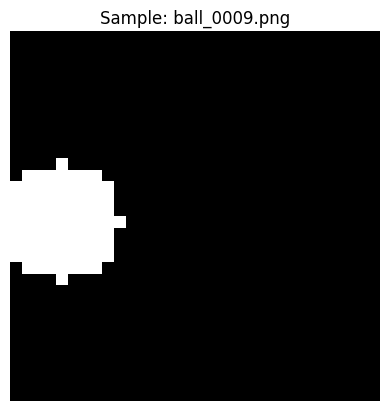

In [10]:
import cv2
import numpy as np
import os
import random

# ==========================================
# CONFIGURATION
# ==========================================
OUTPUT_RAW_FOLDER = "../data/tests/test2/raw_images"  # Folder output gambar
NUM_IMAGES = 10         # Berapa banyak gambar yang mau dibuat
IMG_SIZE = (32, 32)     # Ukuran gambar (Height, Width)

# ==========================================
# PATTERN GENERATOR FUNCTIONS
# ==========================================
def create_moving_ball(idx, size):
    """Membuat bola putih yang bergerak dari kiri ke kanan"""
    img = np.zeros(size, dtype=np.uint8)
    radius = size[0] // 6
    
    # Gerak bola berdasarkan index (frame)
    # x akan bergerak dari kiri ke kanan lalu loop
    speed = 4
    x = (idx * speed) % size[1]
    y = size[0] // 2 # Tengah vertikal
    
    cv2.circle(img, (x, y), radius, 255, -1)
    return img

def create_diagonal_line(idx, size):
    """Membuat garis diagonal yang berjalan"""
    img = np.zeros(size, dtype=np.uint8)
    thickness = 2
    
    # Offset garis bergerak
    offset = (idx * 2) % size[1]
    
    # Gambar garis diagonal
    cv2.line(img, (0, offset), (size[1], size[0] + offset), 255, thickness)
    # Gambar garis kedua (looping effect)
    cv2.line(img, (0, offset - size[0]), (size[1], offset), 255, thickness)
    
    return img

def create_random_box(idx, size):
    """Membuat kotak di posisi random"""
    img = np.zeros(size, dtype=np.uint8)
    box_size = size[0] // 4
    
    # Random posisi (tapi deterministik pakai seed idx biar bisa direpro)
    np.random.seed(idx) 
    x = np.random.randint(0, size[1] - box_size)
    y = np.random.randint(0, size[0] - box_size)
    
    cv2.rectangle(img, (x, y), (x+box_size, y+box_size), 255, -1)
    return img

# ==========================================
# MAIN EXECUTION
# ==========================================
def generate_synthetic_data():
    if not os.path.exists(OUTPUT_RAW_FOLDER):
        os.makedirs(OUTPUT_RAW_FOLDER)
        print(f"📁 Membuat folder baru: {OUTPUT_RAW_FOLDER}")
    
    print(f"🎨 Generating {NUM_IMAGES} synthetic images ({IMG_SIZE[0]}x{IMG_SIZE[1]})...")
    
    for i in range(NUM_IMAGES):
        # Pilih pola secara bergantian atau random
        # Disini kita buat urutan: Bola -> Garis -> Kotak
        pattern_type = i % 3
        
        if pattern_type == 0:
            img = create_moving_ball(i, IMG_SIZE)
            prefix = "ball"
        elif pattern_type == 1:
            img = create_diagonal_line(i, IMG_SIZE)
            prefix = "line"
        else:
            img = create_random_box(i, IMG_SIZE)
            prefix = "box"
            
        # Simpan Gambar
        filename = f"{prefix}_{i:04d}.png"
        filepath = os.path.join(OUTPUT_RAW_FOLDER, filename)
        cv2.imwrite(filepath, img)
        print(f"   Saved: {filename}")

    print("-" * 30)
    print(f"✅ Selesai! Cek folder '{OUTPUT_RAW_FOLDER}'")
    
    # Opsional: Tampilkan 1 gambar terakhir untuk konfirmasi
    import matplotlib.pyplot as plt
    plt.imshow(img, cmap='gray')
    plt.title(f"Sample: {filename}")
    plt.axis('off')
    plt.show()

# Jalankan Generator
generate_synthetic_data()

In [11]:
import os
import cv2
import numpy as np
import glob

# ==========================================
# 1. CONFIGURATION (UBAH DISINI)
# ==========================================
# Folder tempat gambar asli berada (Input)
INPUT_FOLDER  = "../data/tests/test2/raw_images" 

# Folder untuk menyimpan file CSV (Output)
OUTPUT_FOLDER = "../data/tests/test2" 
OUTPUT_FILENAME = "test2_input.csv"

# Target Ukuran Image (Height, Width)
# Ubah jadi (64, 64) atau berapapun sesuai arsitektur kamu
TARGET_SIZE = (32, 32) 

# Konfigurasi Hardware Fixed Point
SCALE_FACTOR = 1024.0  # Q6.10 (2^10)
NORMALIZE_TO_NEG1_1 = True # Jika True: 0..255 -> -1..1. Jika False: 0..255 -> 0..1

# ==========================================
# 2. PROCESSING SCRIPT
# ==========================================
def generate_rtl_input():
    # Buat folder output jika belum ada
    os.makedirs(OUTPUT_FOLDER, exist_ok=True)
    
    # Cari semua gambar (jpg, png, jpeg)
    extensions = ['*.png', '*.jpg', '*.jpeg', '*.bmp']
    img_paths = []
    for ext in extensions:
        img_paths.extend(glob.glob(os.path.join(INPUT_FOLDER, ext)))
    
    img_paths.sort() # Urutkan supaya urutan di CSV konsisten
    
    if not img_paths:
        print(f"❌ Error: Tidak ada gambar ditemukan di {INPUT_FOLDER}")
        return

    all_vectors = []
    print(f"🔄 Processing {len(img_paths)} images to size {TARGET_SIZE}...")

    for i, path in enumerate(img_paths):
        # A. Baca Image (Force Grayscale)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        
        if img is None:
            print(f"   ⚠️ Warning: Gagal membaca {path}, skip.")
            continue
            
        # B. Resize ke Target Size
        img_resized = cv2.resize(img, (TARGET_SIZE[1], TARGET_SIZE[0]), interpolation=cv2.INTER_AREA)
        
        # C. Normalisasi & Fixed Point Conversion
        img_float = img_resized.astype(np.float32)
        
        if NORMALIZE_TO_NEG1_1:
            # Convert 0..255 menjadi -1.0 .. 1.0 (Standar GAN Tanh)
            # Rumus: (x / 127.5) - 1.0
            img_norm = (img_float / 127.5) - 1.0
        else:
            # Convert 0..255 menjadi 0.0 .. 1.0
            img_norm = img_float / 255.0
            
        # Convert ke Fixed Point (Q6.10) -> Integer
        img_fixed = np.clip(np.round(img_norm * SCALE_FACTOR), -32768, 32767).astype(np.int32)
        
        # D. Flatten dan Simpan ke List
        # Flatten akan mengubah matrix 2D (32x32) menjadi array 1D (1024)
        all_vectors.extend(img_fixed.flatten())
        
        if i < 3: # Print info untuk 3 gambar pertama saja
            print(f"   Processed: {os.path.basename(path)} -> Shape {img_fixed.shape} -> Flattened size {len(img_fixed.flatten())}")

    # ==========================================
    # 3. SAVE TO CSV
    # ==========================================
    output_path = os.path.join(OUTPUT_FOLDER, OUTPUT_FILENAME)
    
    # Simpan sebagai file text (CSV), satu angka per baris
    # Format '%d' memastikan yang disimpan adalah integer
    np.savetxt(output_path, np.array(all_vectors), fmt='%d')
    
    print("-" * 30)
    print(f"✅ SUKSES!")
    print(f"📁 Output File: {output_path}")
    print(f"📊 Total Data Point: {len(all_vectors)}")
    print(f"🖼️ Total Frame/Image: {len(all_vectors) // (TARGET_SIZE[0] * TARGET_SIZE[1])}")
    print("-" * 30)

# Jalankan Fungsi
generate_rtl_input()

🔄 Processing 10 images to size (32, 32)...
   Processed: ball_0000.png -> Shape (32, 32) -> Flattened size 1024
   Processed: ball_0003.png -> Shape (32, 32) -> Flattened size 1024
   Processed: ball_0006.png -> Shape (32, 32) -> Flattened size 1024
------------------------------
✅ SUKSES!
📁 Output File: ../data/tests/test2/test2_input.csv
📊 Total Data Point: 10240
🖼️ Total Frame/Image: 10
------------------------------


In [25]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import os

# ==========================================
# 1. CONFIGURATION
# ==========================================
# Path sesuai struktur folder kamu
INPUT_CSV   = "../data/tests/test2/test2_input.csv"
REF_OUT_CSV = "../data/tests/test2/pytorch_ref.csv"
WEIGHTS_DIR = "../data/model_csv/model_1"
SCALE       = 1024.0  # Q6.10 Fixed Point

# RTL Padding Config untuk DEC1 & DEC2
# Sesuai RTL generator_v3.v: PAD_TOP=2, PAD_BOTTOM=3, PAD_LEFT=2, PAD_RIGHT=3
PAD_CFG_RTL = (2, 3, 2, 3) # (Left, Right, Top, Bot) order untuk PyTorch F.pad

# ==========================================
# 2. HARDWARE EMULATION FUNCTIONS
# ==========================================
def to_q6_10_numpy(tensor):
    """Convert Float Tensor back to Q6.10 Integer"""
    arr = tensor.detach().cpu().numpy()
    return np.clip(np.round(arr * SCALE), -32768, 32767).astype(np.int32)

def rtl_leaky_relu(x):
    return F.leaky_relu(x, negative_slope=13.0/64.0)

def rtl_trans_conv_padded(x, w, b, pad_order):
    """
    Emulasi Decoder V3: Upsample -> Zero Pad -> Conv Valid
    """
    # 1. Upsample (Insert Zeros)
    B, C, H, W = x.shape
    up = torch.zeros((B, C, H*2, W*2), dtype=x.dtype, device=x.device)
    up[:, :, 0::2, 0::2] = x
    
    # 2. Padding Manual (Sesuai RTL zero_pad_layer)
    padded = F.pad(up, pad_order, mode='constant', value=0)
    
    # 3. Conv Valid
    return F.conv2d(padded, w, bias=b, padding=0)

# ==========================================
# 3. MODEL ARCHITECTURE (GENERATOR V3)
# ==========================================
class GeneratorV3_Ref(torch.nn.Module):
    def __init__(self, w_dir):
        super().__init__()
        self.weights = {}
        self.load_layer("enc1", 3, w_dir)
        self.load_layer("enc2", 4, w_dir)
        self.load_layer("enc3", 4, w_dir)
        self.load_layer("dec1", 4, w_dir)
        self.load_layer("dec2", 4, w_dir)
        self.load_layer("out",  3, w_dir)

    def load_layer(self, name, k_size, w_dir):
        # Load weights sesuai nama file di folder model_1
        w_path = os.path.join(w_dir, f"{name}_weight.csv")
        b_path = os.path.join(w_dir, f"{name}_bias.csv")
        
        if not os.path.exists(w_path):
            print(f"⚠️ Warning: {w_path} missing, using random.")
            w_np = np.random.randn(1, 1, k_size, k_size)
            b_np = np.array([0.0])
        else:
            w_flat = pd.read_csv(w_path, header=None).values.flatten()
            b_val  = pd.read_csv(b_path, header=None).values.flatten()[0]
            w_np = w_flat.reshape(1, 1, k_size, k_size)
            b_np = np.array([b_val])
            
        self.weights[f"{name}_w"] = torch.tensor(w_np, dtype=torch.float32)
        self.weights[f"{name}_b"] = torch.tensor(b_np, dtype=torch.float32)

    def forward(self, x):
        w = self.weights
        # Enc1: 32 -> 30
        x = F.conv2d(x, w["enc1_w"], bias=w["enc1_b"]); x = rtl_leaky_relu(x)
        # Enc2: 30 -> 14 (Stride 2)
        x = F.conv2d(x, w["enc2_w"], bias=w["enc2_b"], stride=2); x = rtl_leaky_relu(x)
        # Enc3: 14 -> 6 (Stride 2)
        x = F.conv2d(x, w["enc3_w"], bias=w["enc3_b"], stride=2); x = rtl_leaky_relu(x)
        
        # Dec1: 6 -> 14 (Upsample + Pad + Conv)
        x = rtl_trans_conv_padded(x, w["dec1_w"], w["dec1_b"], PAD_CFG_RTL); x = rtl_leaky_relu(x)
        # Dec2: 14 -> 30 (Upsample + Pad + Conv)
        x = rtl_trans_conv_padded(x, w["dec2_w"], w["dec2_b"], PAD_CFG_RTL); x = rtl_leaky_relu(x)
        
        # Out: 30 -> 28
        x = F.conv2d(x, w["out_w"], bias=w["out_b"])
        x = torch.tanh(x)
        return x

# ==========================================
# 4. EXECUTION
# ==========================================
if not os.path.exists(INPUT_CSV):
    print(f"❌ Error: Input file {INPUT_CSV} not found!")
else:
    print(f"🔄 Loading input: {INPUT_CSV}")
    raw_input = np.loadtxt(INPUT_CSV, dtype=np.float32)
    
    # Reshape Flat CSV -> (N, 1, 32, 32)
    num_pixels = 32 * 32
    num_frames = len(raw_input) // num_pixels
    input_reshaped = raw_input[:num_frames*num_pixels].reshape(num_frames, 1, 32, 32)
    
    # De-quantize (Q6.10 Integer -> Float)
    input_tensor = torch.tensor(input_reshaped / SCALE)
    
    # Run Inference
    model = GeneratorV3_Ref(WEIGHTS_DIR)
    model.eval()
    
    print("🧠 Running PyTorch Model...")
    with torch.no_grad():
        out_tensor = model(input_tensor)
        
    # Quantize Result (Float -> Q6.10 Integer)
    out_fixed = to_q6_10_numpy(out_tensor)
    
    # Save
    np.savetxt(REF_OUT_CSV, out_fixed.flatten(), fmt='%d')
    print(f"✅ Reference saved to: {REF_OUT_CSV}")
    print(f"   Processed {num_frames} frames.")

🔄 Loading input: ../data/tests/test2/test2_input.csv
🧠 Running PyTorch Model...
✅ Reference saved to: ../data/tests/test2/pytorch_ref.csv
   Processed 10 frames.


🔎 Comparing 10 frames...
   (RTL has 10, Ref has 10)
----------------------------------------
📊 STATISTICS (Units in Q6.10 Fixed Point)
   MSE (Mean Squared Error): 104.1617
   Max Absolute Error      : 23
   Avg Absolute Error      : 9.7390
⚠️  ACCEPTABLE (Likely precision diffs)
----------------------------------------


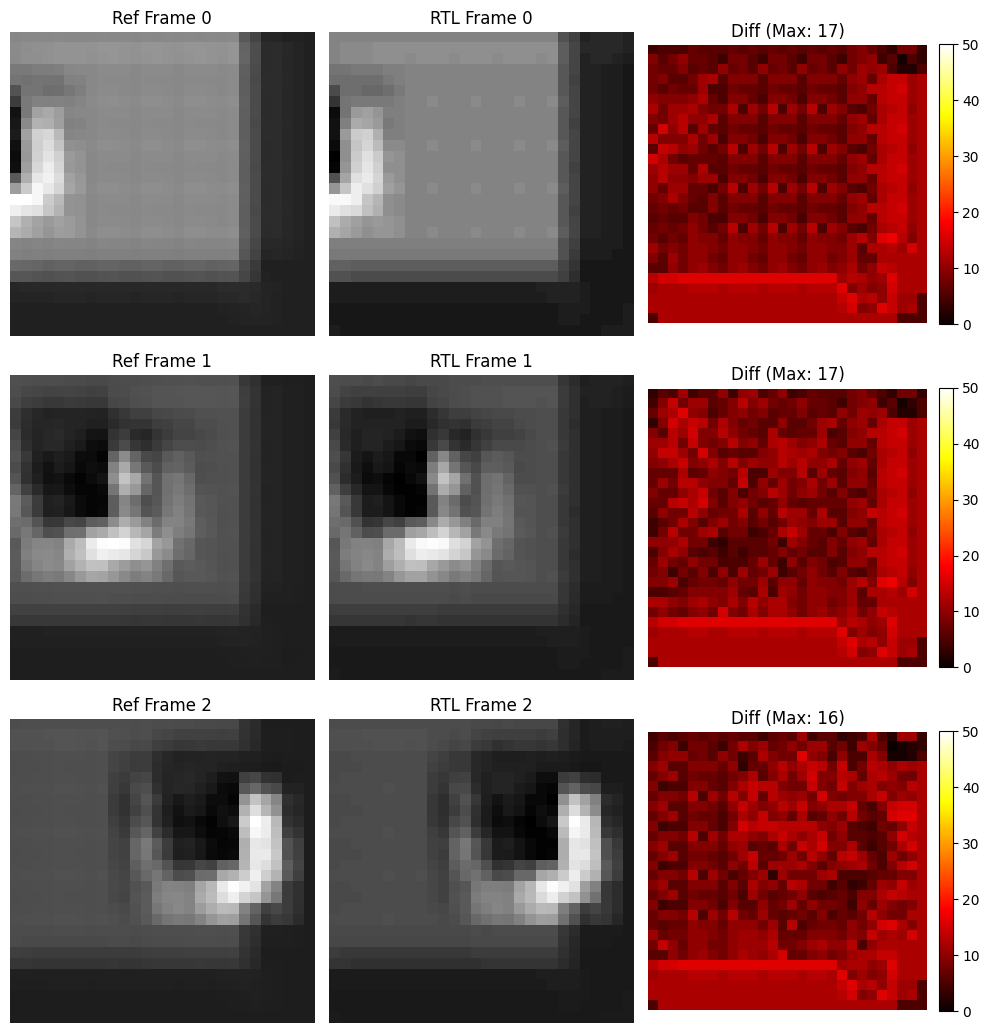

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import os

# ==========================================
# CONFIGURATION
# ==========================================
RTL_CSV = "../data/tests/test2/rtl_out.csv"      # Output dari Simulasi Verilog
REF_CSV = "../data/tests/test2/pytorch_ref.csv"     # Output dari Cell 1 (Golden)

IMG_SIZE = 28  # Ukuran Output V3
SCALE    = 1024.0

# ==========================================
# VALIDATION LOGIC
# ==========================================
def validate_rtl():
    if not os.path.exists(RTL_CSV):
        print(f"❌ RTL Output not found: {RTL_CSV}")
        return
    if not os.path.exists(REF_CSV):
        print(f"❌ Ref Output not found: {REF_CSV}")
        return

    # 1. Load Data
    try:
        rtl_data = np.loadtxt(RTL_CSV, dtype=np.int32)
        ref_data = np.loadtxt(REF_CSV, dtype=np.int32)
    except Exception as e:
        print(f"Error loading CSV: {e}")
        return

    # 2. Reshape & Align Frames
    pixels = IMG_SIZE * IMG_SIZE
    n_frames_rtl = len(rtl_data) // pixels
    n_frames_ref = len(ref_data) // pixels
    n_frames = min(n_frames_rtl, n_frames_ref) # Bandingkan jumlah frame yang ada di keduanya
    
    print(f"🔎 Comparing {n_frames} frames...")
    print(f"   (RTL has {n_frames_rtl}, Ref has {n_frames_ref})")
    
    if n_frames == 0:
        print("❌ No complete frames found in RTL output!")
        return

    rtl_imgs = rtl_data[:n_frames*pixels].reshape(n_frames, IMG_SIZE, IMG_SIZE)
    ref_imgs = ref_data[:n_frames*pixels].reshape(n_frames, IMG_SIZE, IMG_SIZE)
    
    # 3. Calculate Error Stats
    diff = np.abs(rtl_imgs - ref_imgs)
    max_err = np.max(diff)
    mse = np.mean((rtl_imgs - ref_imgs)**2)
    
    print("-" * 40)
    print(f"📊 STATISTICS (Units in Q6.10 Fixed Point)")
    print(f"   MSE (Mean Squared Error): {mse:.4f}")
    print(f"   Max Absolute Error      : {max_err}")
    print(f"   Avg Absolute Error      : {np.mean(diff):.4f}")
    
    # Ambang batas toleransi (biasanya < 50 untuk fixed point wajar karena rounding)
    if max_err == 0:
        print("✅ PERFECT MATCH!")
    elif max_err < 10:
        print("✅ EXCELLENT MATCH (Rounding noise only)")
    elif max_err < 100:
        print("⚠️  ACCEPTABLE (Likely precision diffs)")
    else:
        print("❌ MISMATCH DETECTED (Check logic/padding)")
    print("-" * 40)

    # 4. Visualization (Show max 3 frames)
    show_n = min(n_frames, 3)
    fig, axes = plt.subplots(show_n, 3, figsize=(10, 3.5 * show_n))
    if show_n == 1: axes = [axes] # Handle single row
    
    for i in range(show_n):
        # Determine shared vmin/vmax for fair comparison
        vmin = min(np.min(rtl_imgs[i]), np.min(ref_imgs[i]))
        vmax = max(np.max(rtl_imgs[i]), np.max(ref_imgs[i]))
        
        # PyTorch Reference
        ax = axes[i][0] if show_n > 1 else axes[0]
        ax.imshow(ref_imgs[i], cmap='gray', vmin=vmin, vmax=vmax)
        ax.set_title(f"Ref Frame {i}")
        ax.axis('off')
        
        # RTL Output
        ax = axes[i][1] if show_n > 1 else axes[1]
        ax.imshow(rtl_imgs[i], cmap='gray', vmin=vmin, vmax=vmax)
        ax.set_title(f"RTL Frame {i}")
        ax.axis('off')
        
        # Difference Heatmap
        ax = axes[i][2] if show_n > 1 else axes[2]
        im = ax.imshow(diff[i], cmap='hot', vmin=0, vmax=max(50, max_err))
        ax.set_title(f"Diff (Max: {np.max(diff[i])})")
        ax.axis('off')
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

# Run
validate_rtl()